# Import Dog Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/dogbreedidentification.zip

In [ ]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

#Number of Dog Image and Breeds

In [ ]:
breed_list = os.listdir("../content/dogbreedidentification/images/Images/")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("../content/dogbreedidentification/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

63 breeds
10810 images


# Breed Label

In [ ]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [ ]:
label_maps_rev


In [ ]:
label_maps

In [ ]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "../content/dogbreedidentification/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02102318-cocker_spaniel


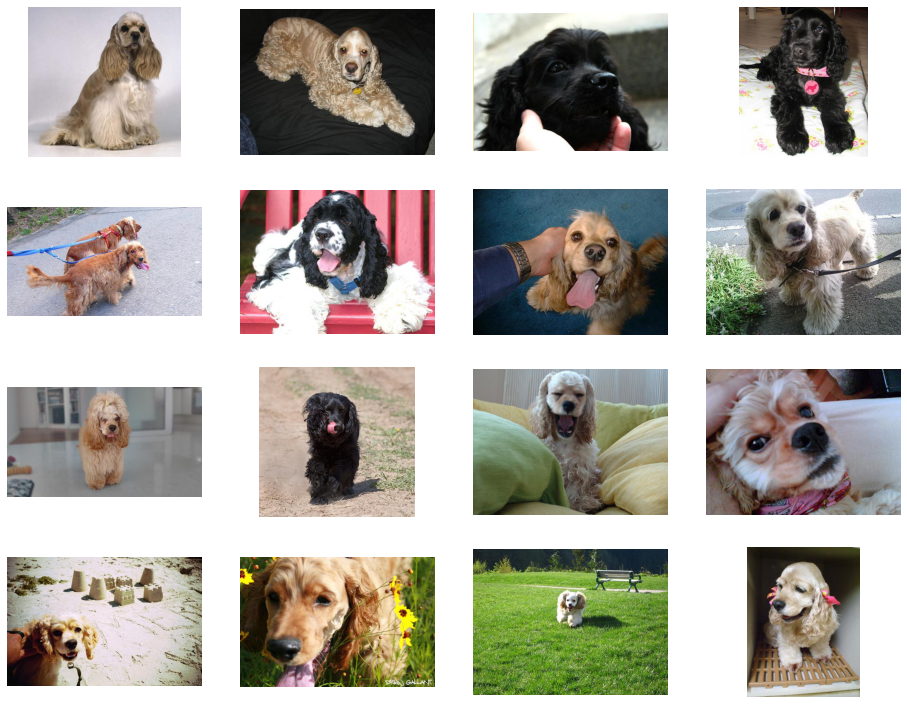

In [ ]:
print(breed_list[0])
show_dir_images(breed_list[0], 16)

# Crop Images 224 by 224

In [ ]:
%%time

os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('/content/dogbreedidentification/annotations/Annotation/{}'.format(breed)):
        img = Image.open('/content/dogbreedidentification/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('/content/dogbreedidentification/annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')
        

Created 63 folders to store cropped images of the different breeds.
CPU times: user 1min 31s, sys: 2.84 s, total: 1min 34s
Wall time: 1min 36s


In [ ]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)


# image generator with augment

In [ ]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image


# Split Train and Test

In [ ]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=64, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=64, shape=(224,224,3), augment=False)

# Train densenet121 model

In [ ]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights='/content/DenseNet-BC-121-32-no-top.h5',
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

In [ ]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [ ]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=25)

Epoch 1/25
  3/144 [..............................] - ETA: 25:44 - loss: 4.5911 - acc: 0.0365

KeyboardInterrupt: ignored

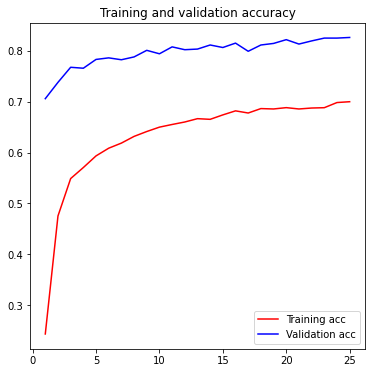

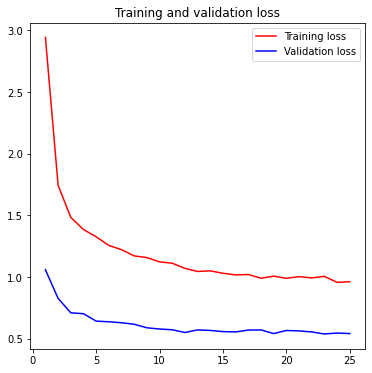

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
for layer in model.layers[:]:
    layer.trainable = True

In [ ]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [ ]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=40,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/40
144/144 [==============================] - ETA: 0s - loss: 0.9564 - acc: 0.6969
Epoch 1: val_acc improved from -inf to 0.81134, saving model to dog_breed_classifier_model.h5
144/144 [==============================] - 50s 349ms/step - loss: 0.9564 - acc: 0.6969 - val_loss: 0.5550 - val_acc: 0.8113 - lr: 0.0010
Epoch 2/40
144/144 [==============================] - ETA: 0s - loss: 0.9485 - acc: 0.6944
Epoch 2: val_acc improved from 0.81134 to 0.81689, saving model to dog_breed_classifier_model.h5
144/144 [==============================] - 50s 348ms/step - loss: 0.9485 - acc: 0.6944 - val_loss: 0.5509 - val_acc: 0.8169 - lr: 0.0010
Epoch 3/40
144/144 [==============================] - ETA: 0s - loss: 0.9470 - acc: 0.7054
Epoch 3: val_acc improved from 0.81689 to 0.82059, saving model to dog_breed_classifier_model.h5
144/144 [==============================] - 49s 343ms/step - loss: 0.9470 - acc: 0.7054 - val_loss: 0.5420 - val_acc: 0.8206 - lr: 0.0010
Epoch 4/40
144/144 [========

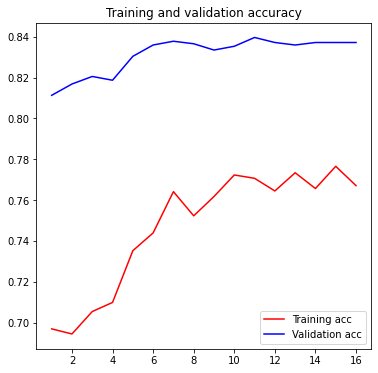

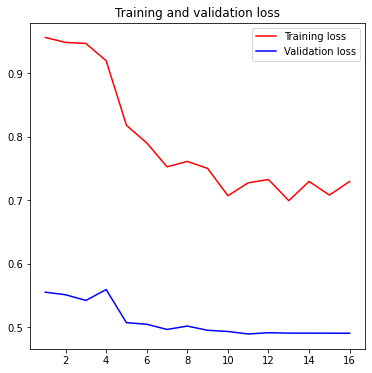

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
print("Accuracy:", (max(val_acc)*100),"%")

Accuracy: 83.97040963172913 %


# Predict New Images

download some dog images from pixabay for testing

In [ ]:

def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

1/1 [==============================] - 0s 65ms/step
42.07% 	 silky_terrier
32.06% 	 Yorkshire_terrier
6.39% 	 standard_schnauzer
6.15% 	 Australian_terrier
2.04% 	 Tibetan_terrier


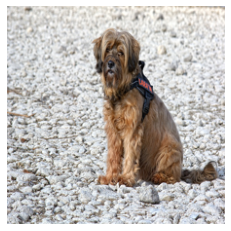

In [ ]:
download_and_predict("https://cdn.pixabay.com/photo/2016/11/01/17/21/dog-1788986_960_720.jpg",
                     "test_123.jpg")

1/1 [==============================] - 0s 247ms/step
100.00% 	 pug
0.00% 	 bull_mastiff
0.00% 	 malinois
0.00% 	 standard_schnauzer
0.00% 	 Pekinese


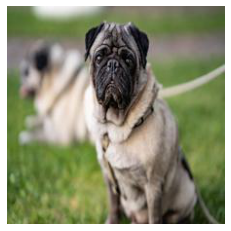

In [ ]:
filename = 'test_4.jpg'

img = Image.open(filename)
img = img.convert('RGB')
img = img.resize((224, 224))
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')

img = imread(filename)
img = preprocess_input(img)
probs = model.predict(np.expand_dims(img, axis=0))
for idx in probs.argsort()[0][::-1][:5]:
    print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

In [ ]:
!pip install anvil-uplink

In [ ]:
import anvil.server

anvil.server.connect("NDRR3KVDSAUKQKZXQ5STZUGF-7Y72USGCYYQJLUDJ")



Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [ ]:
import anvil.media
import io
@anvil.server.callable
def classify_image(file):
    img = Image.open(io.BytesIO(file.get_bytes()))
    img = img.convert('RGB')
    img = img.resize((224,224))

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')

    img = imread(io.BytesIO(file.get_bytes()))
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    result = []
    for idx in probs.argsort()[0][::-1][:5]:
        result.append("Result: {} | Confidence: {:.2f}%".format(label_maps_rev[idx].split("-")[-1], probs[0][idx]*100))
    return "\n".join(result)

# Cleaning

In [ ]:
//!rm -rf data/* 

In [ ]:
//!rm -f test_*.jpg